# Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)},
        font_scale=1.5,
        style="whitegrid")
        
from pyspark.sql import HiveContext
from pyspark.sql import SQLContext

# initialize session hive and sql environments
hiveContext = HiveContext(sc)
sqlContext = SQLContext(sc)

# Data Reading

In [3]:
project_folder = "../"
datapath = project_folder + "data/"
plotpath = project_folder + "graphs/"
mungepath = project_folder + "munge/"
configpath = project_folder + "config/"
diagnostic = project_folder + "diagnostic/"
modelpath = project_folder + "model/"
output = project_folder + "output/"

In [4]:
from pyspark.sql.functions import col

train = spark.read.csv(os.path.join(datapath,"train.csv"), header=True)
print('Found %d observations in training set.' %train.count())

Found 184903890 observations in training set.


In [5]:
from pyspark.sql.functions import col

test_old = (spark.read.csv(os.path.join(datapath,"test_supplement.csv"), header=True)
            .filter(col('click_time') >= '2017-11-09 16:00:00'))

print('Found %d observations in test_old set.' %test_old.count())

Found 57536872 observations in test_old set.


In [6]:
train.show(10)

+------+---+------+---+-------+-------------------+---------------+-------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|           null|            0|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|           null|            0|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|           null|            0|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|           null|            0|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|           null|            0|
| 18787|  3|     1| 16|    379|2017-11-06 14:36:26|           null|            0|
|103022|  3|     1| 23|    379|2017-11-06 14:37:44|           null|            0|
|114221|  3|     1| 19|    379|2017-11-06 14:37:59|           null|            0|
|165970|  3|     1| 13|    379|2017-11-06 14:38:10|           null|            0|
| 74544| 64|    

In [7]:
train.printSchema()

root
 |-- ip: string (nullable = true)
 |-- app: string (nullable = true)
 |-- device: string (nullable = true)
 |-- os: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: string (nullable = true)



# Build the full dataset

In [8]:
# train and test set concatenation
from pyspark.sql.functions import col
data = (train.select('ip', 'app', 'device', 'os', 'channel', 'click_time')
        .unionAll(test_old.select('ip', 'app', 'device', 'os', 'channel', 'click_time')))
        
print('Total number of clicks in one week:', data.count())

Total number of clicks in one week: 242440762


In [9]:
data.show(5)

+------+---+------+---+-------+-------------------+
|    ip|app|device| os|channel|         click_time|
+------+---+------+---+-------+-------------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|
+------+---+------+---+-------+-------------------+
only showing top 5 rows



# Datetime Features

In [10]:
# day function
def get_day(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        day: A String containing the day of click ("06", "07", .."10")
    """
    
    return date[8:10]

# hour function
def get_hour(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the hour interval ("01", "02", .."23")
    """
    
    return date[11:13]

# minute function
def get_minute(date):
    """
    Returns the minute based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the minute interval ("01", "02", .."59")
    """
    
    return date[14:16]

In [11]:
# Get datetime features
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

day_udf = udf(get_day, StringType())
hour_udf = udf(get_hour, StringType())
minute_udf = udf(get_minute, StringType())

data = data.withColumn('day', day_udf(data.click_time))
data = data.withColumn('hour', hour_udf(data.click_time))
data = data.withColumn('minute', minute_udf(data.click_time))

In [12]:
data.show(5)

+------+---+------+---+-------+-------------------+---+----+------+
|    ip|app|device| os|channel|         click_time|day|hour|minute|
+------+---+------+---+-------+-------------------+---+----+------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21| 06|  14|    32|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34| 06|  14|    33|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12| 06|  14|    34|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52| 06|  14|    34|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08| 06|  14|    35|
+------+---+------+---+-------+-------------------+---+----+------+
only showing top 5 rows



# IP Number of Clicks with same DEVICE

In [ ]:
from pyspark.sql.functions import col, unix_timestamp, lit
import pyspark.sql.functions as func

In [34]:
var = 'device'

In [45]:
train.groupBy().agg(func.min('click_time')).show()

+-------------------+
|    min(click_time)|
+-------------------+
|2017-11-06 14:32:21|
+-------------------+



In [37]:
ip_var_clicks = (data
                 .withColumn('click_time_seconds',
                             (unix_timestamp(col('click_time')) - unix_timestamp(lit('2017-11-06 14:32:21'))))
                 .groupBy('ip', var)
                 .agg(func.count(func.lit(1)).alias('ip_'+var+'_clicks'),
                      func.round(func.stddev(col('click_time_seconds'))).alias('ip_'+var+'_std_click_time'),
                      func.round(func.stddev(col('hour')), 2).alias('ip_'+var+'_std_hour'),
                      func.round(func.stddev(col('minute')), 2).alias('ip_'+var+'_std_minute'),
                      func.round(func.mean(col('hour')), 2).alias('ip_'+var+'_avg_hour'),
                      func.round(func.mean(col('minute')), 2).alias('ip_'+var+'_avg_minute'))
                 .fillna({'ip_'+var+'_std_click_time':0,
                          'ip_'+var+'_std_hour':0,
                          'ip_'+var+'_std_minute':0,
                          'ip_'+var+'_avg_hour':0,
                          'ip_'+var+'_avg_minute':0})
                 .cache())

ip_var_clicks.show(100, truncate=False)

+------+------+----------------+------------------------+------------------+--------------------+------------------+--------------------+
|ip    |device|ip_device_clicks|ip_device_std_click_time|ip_device_std_hour|ip_device_std_minute|ip_device_avg_hour|ip_device_avg_minute|
+------+------+----------------+------------------------+------------------+--------------------+------------------+--------------------+
|84942 |1     |16261           |103078.0                |6.11              |17.22               |11.06             |28.86               |
|69358 |1     |9519            |91202.0                 |7.57              |17.84               |11.65             |29.07               |
|64756 |1     |19379           |95525.0                 |6.44              |17.32               |8.33              |29.0                |
|123759|1     |32899           |99188.0                 |6.4               |17.49               |10.43             |29.51               |
|105560|2     |20341           |85

In [16]:
data.filter((col('ip')==186995) & (col(var)==3032)).show(truncate=False)

+------+---+------+---+-------+-------------------+---+----+------+
|ip    |app|device|os |channel|click_time         |day|hour|minute|
+------+---+------+---+-------+-------------------+---+----+------+
|186995|68 |3032  |607|347    |2017-11-06 22:48:27|06 |22  |48    |
+------+---+------+---+-------+-------------------+---+----+------+



In [18]:
data.filter((col('ip')==172033) & (col(var)==1)).show(truncate=False)

+------+---+------+---+-------+-------------------+---+----+------+
|ip    |app|device|os |channel|click_time         |day|hour|minute|
+------+---+------+---+-------+-------------------+---+----+------+
|172033|18 |1     |19 |107    |2017-11-06 22:48:33|06 |22  |48    |
|172033|18 |1     |19 |107    |2017-11-06 23:24:59|06 |23  |24    |
|172033|18 |1     |19 |107    |2017-11-07 13:12:43|07 |13  |12    |
|172033|2  |1     |19 |122    |2017-11-07 13:12:44|07 |13  |12    |
|172033|18 |1     |19 |107    |2017-11-07 13:27:03|07 |13  |27    |
+------+---+------+---+-------+-------------------+---+----+------+



In [19]:
train.filter((col('ip')==172033) & (col(var)==1)).show(truncate=False)

+------+---+------+---+-------+-------------------+---------------+-------------+
|ip    |app|device|os |channel|click_time         |attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
|172033|18 |1     |19 |107    |2017-11-06 22:48:33|null           |0            |
|172033|18 |1     |19 |107    |2017-11-06 23:24:59|null           |0            |
|172033|18 |1     |19 |107    |2017-11-07 13:12:43|null           |0            |
|172033|2  |1     |19 |122    |2017-11-07 13:12:44|null           |0            |
|172033|18 |1     |19 |107    |2017-11-07 13:27:03|null           |0            |
+------+---+------+---+-------+-------------------+---------------+-------------+



## Export New Features

In [86]:
(ip_var_clicks
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_ip_"+var+"_clicks", compression="None"))

In [85]:
ip_var_clicks.count()

911450

## Check the impact of new features

In [26]:
import pyspark.sql.functions as func

train.groupBy().agg(func.mean(col('is_attributed'))).show()

+--------------------+
|  avg(is_attributed)|
+--------------------+
|0.002470721410998979|
+--------------------+



In [20]:
train_sample = (train.sample(fraction=0.05, withReplacement=False, seed=22)
                .join(ip_var_clicks, ['ip', var], 'left_outer')
                .cache())

In [23]:
train_sample.count()

9248009

In [24]:
train.sample(fraction=0.05, withReplacement=False, seed=22).count()

9248009

In [21]:
train_sample.show(5, truncate=False)

+------+------+---+---+-------+-------------------+---------------+-------------+----------------+------------------------+------------------+--------------------+------------------+--------------------+
|ip    |device|app|os |channel|click_time         |attributed_time|is_attributed|ip_device_clicks|ip_device_std_click_time|ip_device_std_hour|ip_device_std_minute|ip_device_avg_hour|ip_device_avg_minute|
+------+------+---+---+-------+-------------------+---------------+-------------+----------------+------------------------+------------------+--------------------+------------------+--------------------+
|38816 |1     |3  |18 |379    |2017-11-06 14:40:39|null           |0            |5482            |101015.0                |5.98              |17.15               |7.76              |29.76               |
|134575|1     |3  |13 |379    |2017-11-06 14:43:10|null           |0            |3243            |67858.0                 |6.4               |17.24               |10.01             |31

### ip_device_clicks

In [50]:
feature = 'ip_device_clicks'

In [22]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [23]:
PDF.head()

,is_attributed,ip_device_clicks
0,0,5482
1,0,3243
2,0,6973
3,0,1003
4,0,16939


In [24]:
PDF_sorted = PDF.sort_values(by=feature)

In [25]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [26]:
PDF_sorted.head()

,is_attributed,ip_device_clicks,roll
2626850,0,1,NaN
8774463,0,1,NaN
4278470,1,1,NaN
1513233,0,1,NaN
5572114,0,1,NaN


Let's visualize the impact of of last click lapse time variable on the download rate

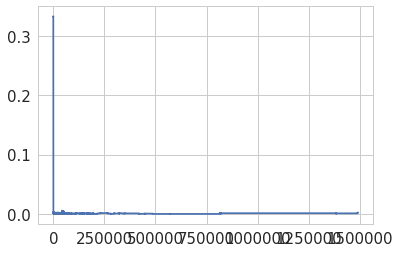

In [27]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

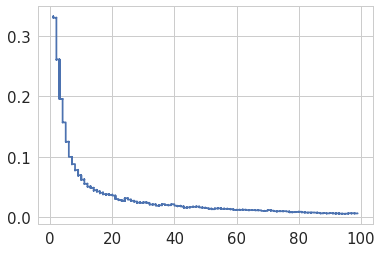

In [30]:
PDF_filtered = PDF_sorted[PDF_sorted[feature]<100]

plt.plot(PDF_filtered[feature], PDF_filtered.roll)

Very strong feature !

### ip_device_std_click_time

In [43]:
feature = 'ip_device_std_click_time'

In [38]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [41]:
PDF.head()

,is_attributed,ip_device_std_click_time
0,0,101015.0
1,0,67858.0
2,0,95519.0
3,0,50859.0
4,0,61145.0


In [44]:
PDF_sorted = PDF.sort_values(by=feature)

In [45]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [46]:
PDF_sorted.head()

,is_attributed,ip_device_std_click_time,roll
5275865,1,0.0,NaN
9172290,0,0.0,NaN
8098222,0,0.0,NaN
5070159,0,0.0,NaN
2398788,0,0.0,NaN


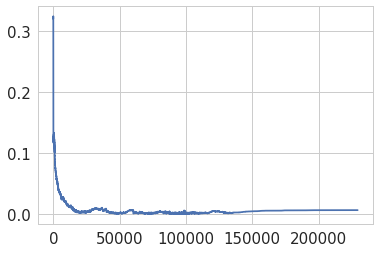

In [47]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

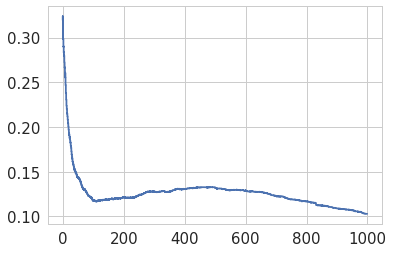

In [49]:
PDF_filtered = PDF_sorted[PDF_sorted[feature]<1000]

plt.plot(PDF_filtered[feature], PDF_filtered.roll)

Very strong feature !

### ip_device_std_hour

In [51]:
feature = 'ip_device_std_hour'

In [52]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [53]:
PDF.head()

,is_attributed,ip_device_std_hour
0,0,5.98
1,0,6.40
2,0,6.14
3,0,5.51
4,0,6.40


In [54]:
PDF_sorted = PDF.sort_values(by=feature)

In [55]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [56]:
PDF_sorted.head()

,is_attributed,ip_device_std_hour,roll
5089809,0,0.0,NaN
3232801,0,0.0,NaN
35951,0,0.0,NaN
8308308,0,0.0,NaN
7325175,0,0.0,NaN


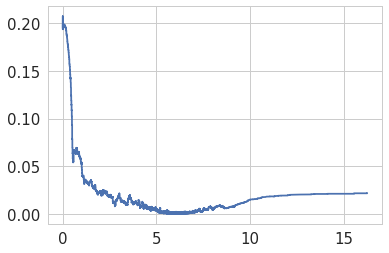

In [57]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very strong feature !

### ip_device_std_minute

In [59]:
feature = 'ip_device_std_minute'

In [60]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [61]:
PDF.head()

,is_attributed,ip_device_std_minute
0,0,17.15
1,0,17.24
2,0,17.36
3,0,15.28
4,0,17.30


In [62]:
PDF_sorted = PDF.sort_values(by=feature)

In [63]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [64]:
PDF_sorted.head()

,is_attributed,ip_device_std_minute,roll
7968749,0,0.0,NaN
3638679,0,0.0,NaN
3638472,0,0.0,NaN
4495182,1,0.0,NaN
8503268,0,0.0,NaN


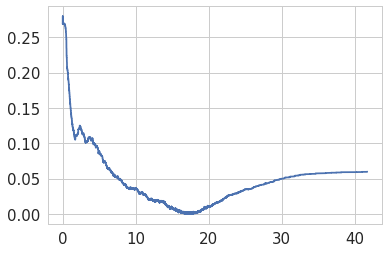

In [65]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very strong feature !

### ip_device_avg_hour

In [71]:
feature = 'ip_device_avg_hour'

In [72]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [73]:
PDF.head()

,is_attributed,ip_device_avg_hour
0,0,7.76
1,0,10.01
2,0,7.62
3,0,10.57
4,0,10.53


In [74]:
PDF_sorted = PDF.sort_values(by=feature)

In [75]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [76]:
PDF_sorted.head()

,is_attributed,ip_device_avg_hour,roll
6663835,0,0.0,NaN
3556956,0,0.0,NaN
629914,0,0.0,NaN
3610604,0,0.0,NaN
3597337,0,0.0,NaN


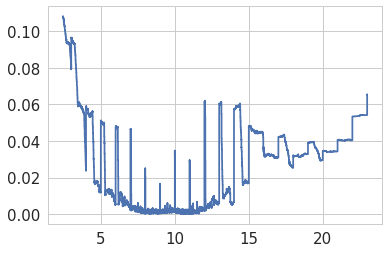

In [77]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very interesting feature !  
It looks like ip addresses that use same device in average between 5 and 15 download much less.

### ip_device_avg_minute

In [78]:
feature = 'ip_device_avg_minute'

In [79]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [80]:
PDF.head()

,is_attributed,ip_device_avg_minute
0,0,29.76
1,0,31.47
2,0,29.62
3,0,30.28
4,0,29.70


In [81]:
PDF_sorted = PDF.sort_values(by=feature)

In [82]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [83]:
PDF_sorted.head()

,is_attributed,ip_device_avg_minute,roll
4908372,1,0.0,NaN
2525740,1,0.0,NaN
646248,0,0.0,NaN
3777581,0,0.0,NaN
2687568,0,0.0,NaN


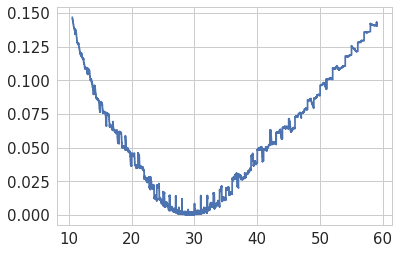

In [84]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very strong feature !  
It looks like ip addresses that use same device in average at the half of a minute download much less.  